In [1]:
## Preliminaries

using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))

using AdvancedHMC
using ArviZ
using BumpCosmologyGWTC3
using CairoMakie
using Colors
using Cosmology
using DataFrames
using DimensionalData
using Distributions
using GaussianKDEs
using HDF5
using InferenceObjects
using Interpolations
using JSON
using LaTeXStrings
using MCMCChainsStorage
using NCDatasets
using PairPlots
using PolyLog
using PopModels
using Printf
using ProgressLogging
using Random
using StatsBase
using SpecialFunctions
using StatsFuns
using Trapz
using Turing
using Unitful
using UnitfulAstro
using UnitfulChainRules

include("plots.jl")

  Activating project at `~/35Msun_GWTC3/m1m2_cut`


h_plot (generic function with 1 method)

In [2]:
## Output Directory for Plots
outdir = "/mnt/home/sroy1/35Msun_GWTC3/paper_plots/plots/"

## Plot Specifications
xlabelsize = 30
ylabelsize = 30
xticklabelsize = 23
yticklabelsize = 23
titlesize = 35
draws = 500

plot_save = true

true

# Load Traces

In [3]:
trace_samples_0p5 = from_netcdf(joinpath(@__DIR__, "..", "data", "chains_0.5.nc"))
ne_min = dropdims(minimum(trace_samples_0p5.posterior.Neff_samps, dims=(:chain, :draw)); dims=(:chain, :draw))
ns_min = minimum(trace_samples_0p5.posterior.Neff_sel)
@info "p_cut = 0.5, minimum Neff_samps: $(round(minimum(ne_min), digits=2)), minimum Neff_sel = $(round(ns_min, digits=1)), 4*Nobs = $(4*length(dims(trace_samples_0p5.posterior, :event)))"

┌ Info: p_cut = 0.5, minimum Neff_samps: 4.25, minimum Neff_sel = 1801.0, 4*Nobs = 204
└ @ Main /mnt/home/sroy1/35Msun_GWTC3/m1m2_cut/scripts/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sdnNjb2RlLXJlbW90ZQ==.jl:4


In [4]:
trace_samples_0p1 = from_netcdf(joinpath(@__DIR__, "..", "data", "chains_0.1.nc"))
ne_min = dropdims(minimum(trace_samples_0p1.posterior.Neff_samps, dims=(:chain, :draw)); dims=(:chain, :draw))
ns_min = minimum(trace_samples_0p1.posterior.Neff_sel)
@info "p_cut = 0.1, minimum Neff_samps: $(round(minimum(ne_min), digits=2)), minimum Neff_sel = $(round(ns_min, digits=1)), 4*Nobs = $(4*length(dims(trace_samples_0p1.posterior, :event)))"

┌ Info: p_cut = 0.1, minimum Neff_samps: 4.19, minimum Neff_sel = 1277.8, 4*Nobs = 220
└ @ Main /mnt/home/sroy1/35Msun_GWTC3/m1m2_cut/scripts/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sdnNjb2RlLXJlbW90ZQ==.jl:4


In [5]:
trace_samples_0p9 = from_netcdf(joinpath(@__DIR__, "..", "data", "chains.nc"))
ne_min = dropdims(minimum(trace_samples_0p5.posterior.Neff_samps, dims=(:chain, :draw)); dims=(:chain, :draw))
ns_min = minimum(trace_samples_0p9.posterior.Neff_sel)
@info "p_cut = 0.9, minimum Neff_samps: $(round(minimum(ne_min), digits=2)), minimum Neff_sel = $(round(ns_min, digits=1)), 4*Nobs = $(4*length(dims(trace_samples_0p9.posterior, :event)))"

┌ Info: p_cut = 0.9, minimum Neff_samps: 4.25, minimum Neff_sel = 894.4, 4*Nobs = 176
└ @ Main /mnt/home/sroy1/35Msun_GWTC3/m1m2_cut/scripts/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W5sdnNjb2RlLXJlbW90ZQ==.jl:4


In [6]:
trace_Mc = from_netcdf("/mnt/home/sroy1/35Msun_GWTC3/Mc_cut/data/chains_0.5.nc")
ne_min = dropdims(minimum(trace_Mc.posterior.Neff_samps, dims=(:chain, :draw)); dims=(:chain, :draw))
ns_min = minimum(trace_Mc.posterior.Neff_sel)
@info "p_cut = 0.5, minimum Neff_samps: $(round(minimum(ne_min), digits=2)), minimum Neff_sel = $(round(ns_min, digits=1)), 4*Nobs = $(4*length(dims(trace_Mc.posterior, :event)))"

┌ Info: p_cut = 0.5, minimum Neff_samps: 4.29, minimum Neff_sel = 919.9, 4*Nobs = 172
└ @ Main /mnt/home/sroy1/35Msun_GWTC3/m1m2_cut/scripts/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W6sdnNjb2RlLXJlbW90ZQ==.jl:4


# Compute Marginal $m_2$ with Different Cuts

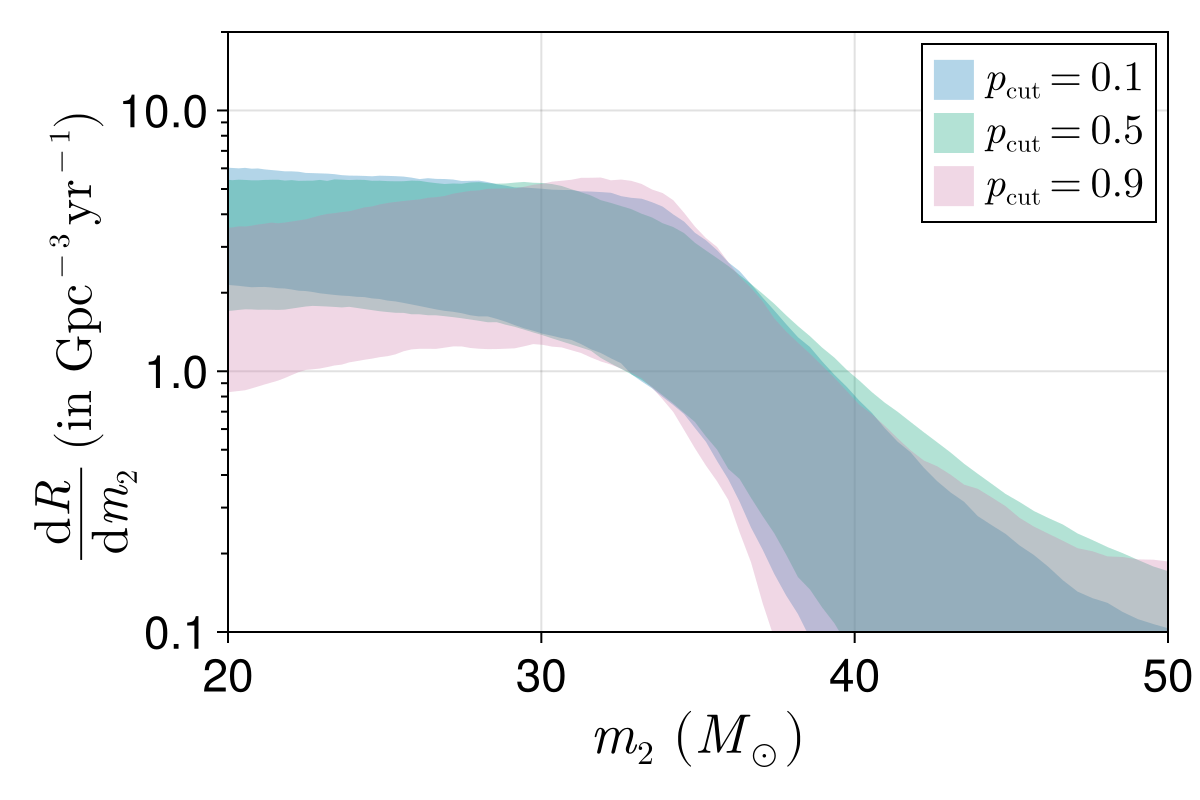

In [ ]:
z_plot = 0.0
ms = exp.(log(m_bh_min):0.01:log(m_bh_max))
m2s = exp.(log(m_bh_min):0.01:log(m_bh_max)) 
draws = draws
rng = Random.default_rng()
limits = (20, 50, 0.1, 20)  
yticks = [0.1, 1, 10, 100]
yminorticks = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,2,3,4,5,6,7,8,9,20,30,40,50,60,70,80,90]
colors = Makie.wong_colors()
color_01, color_05, color_09 = colors[1], colors[3], colors[4]

f = Figure(size=(600, 400))
a = Axis(f[1, 1],
    xlabel = L"m_2~(M_\odot)",
    ylabel = L"\frac{\mathrm{d} R}{\mathrm{d} m_2}~(\mathrm{in~}\mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1})",
    yscale = log10,
    yticks = yticks,
    yminorticks = yminorticks,
    yminorticksvisible = true,
    ytickformat = "{:.1f}",
    xtickformat = xs -> map(x -> isinteger(x) ? string(Int(x)) : string(round(x; digits=1)), xs),
    xlabelsize = 28,
    ylabelsize = 25,
    xticklabelsize = xticklabelsize,
    yticklabelsize = yticklabelsize,
    limits = limits
)

function compute_dNd_m2(trace, color, label)
    p = trace.posterior
    dNdm2_matrix = zeros(length(m2s), draws)

    @progress for i in 1:draws
        d = rand(rng, span(dims(p, :draw)))
        c = rand(rng, span(dims(p, :chain)))
        log_dN = log_dN_from_chain_sample(trace, d, c)

        dNdm2 = map(m2s) do m2
            integrand = map(ms) do m1
                if m1 < m2 || m2 < m_bh_min
                    0.0
                else
                    q = m2 / m1
                    exp(log_dN(m1, q, 0.0, z_plot, 0.0; ignore_chi_eff=true))
                end
            end
            p.R[chain=c, draw=d] * trapz(ms, integrand)
        end

        dNdm2_matrix[:, i] = dNdm2
    end

    q5 = mapslices(x -> quantile(x, 0.05), dNdm2_matrix; dims=2)[:]
    q50 = mapslices(x -> quantile(x, 0.50), dNdm2_matrix; dims=2)[:]
    q95 = mapslices(x -> quantile(x, 0.95), dNdm2_matrix; dims=2)[:]

    band!(a, m2s, q5, q95, color=(color, 0.3), label=label)
end

compute_dNd_m2(trace_samples_0p1, color_01, L"p_{\mathrm{cut}}=0.1")
compute_dNd_m2(trace_samples_0p5, color_05, L"p_{\mathrm{cut}}=0.5")
compute_dNd_m2(trace_samples_0p9, color_09, L"p_{\mathrm{cut}}=0.9")

axislegend(a, position = :rt, labelsize = 21, framevisible = true)  # top-right inside the plot

a.ylabelpadding[] = -12

f
